In [1]:
# Last mod: FA 2023 Feb 1 - first version

# Testing XGBoost ages for some science cases

First, let's import some libraries:

In [2]:
import numpy as np #numpy
import pandas as pd
import matplotlib.pyplot as plt  #matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter

import astropy.table  #astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column, MaskedColumn, join
from astropy.visualization import astropy_mpl_style
from scipy.stats import gaussian_kde  #scipy: science python
import os.path

from time import time
from sklearn import manifold, datasets

from itertools import product
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
dr17_master = Table.read("/home/friedel/Astro/Spectro/APOGEE/data/DR17/APOGEE_DR17_MASTER_Feb2023.fits")
chem_age = np.isfinite(dr17_master['spec_age_feb2023'])

our_cat  = dr17_master[chem_age]

In [5]:
our_cat.columns

<TableColumns names=('APOGEE_ID','GaiaEDR3_sourceID','TARGET_ID','ASPCAP_ID','TELESCOPE','FIELD','RA','DEC','GLON','GLAT','J','J_ERR','H','H_ERR','K','K_ERR','AK_TARG','AK_TARG_METHOD','AK_WISE','SFD_EBV','TARGFLAGS','SURVEY','PROGRAMNAME','NVISITS','SNREV','STARFLAGS','ANDFLAGS','VHELIO_AVG','VSCATTER','VERR','N_COMPONENTS','ASPCAP_GRID','FPARAM','ASPCAP_CHI2','PARAM','ASPCAPFLAGS','FELEM','FELEM_ERR','X_H','X_H_ERR','X_M','X_M_ERR','ELEM_CHI2','ELEMFRAC','ELEMFLAG','EXTRATARG','X_H_SPEC','X_M_SPEC','TEFF','TEFF_ERR','LOGG','LOGG_ERR','M_H','M_H_ERR','ALPHA_M','ALPHA_M_ERR','VMICRO','VMACRO','VSINI','TEFF_SPEC','LOGG_SPEC','C_FE','C_FE_SPEC','C_FE_ERR','C_FE_FLAG','CI_FE','CI_FE_SPEC','CI_FE_ERR','CI_FE_FLAG','N_FE','N_FE_SPEC','N_FE_ERR','N_FE_FLAG','O_FE','O_FE_SPEC','O_FE_ERR','O_FE_FLAG','NA_FE','NA_FE_SPEC','NA_FE_ERR','NA_FE_FLAG','MG_FE','MG_FE_SPEC','MG_FE_ERR','MG_FE_FLAG','AL_FE','AL_FE_SPEC','AL_FE_ERR','AL_FE_FLAG','SI_FE','SI_FE_SPEC','SI_FE_ERR','SI_FE_FLAG','S_FE','S_FE

## Age vs. location in the Galaxy (RGal vs ZGal, XGal vs YGal)

In [11]:
import scipy.ndimage as ndimage

In [85]:
def create_median_map(Xin, Yin, weights, xy_range, bins=50):
    # Weighted 2D Histogram
    H,X,Y=np.histogram2d(Xin, Yin, weights=weights, 
                         bins=bins,range=[xy_range[:2], xy_range[2:]])
    XX,YY=np.meshgrid(X,Y)
    X1 = (X[:-1] - X[1:])/2 +X[:-1]
    Y1 = (Y[:-1] - Y[1:])/2 + Y[:-1]
    
    # Unweighted 2D Histogram
    Hc,X1,X2 = np.histogram2d(Xin, Yin, bins=bins, range=[xy_range[:2], xy_range[2:]])
    Hc[Hc<0.0000001]=1
    Ht = H/Hc
    
    # Gaussian filter
    H = ndimage.gaussian_filter(Ht,sigma=(1.0,1.0),order=0)
    # Filter out nans
    Hc,X,Y=np.histogram2d(Xin, Yin, bins=bins,range=[xy_range[:2], xy_range[2:]])
    H[Hc<0.0000001]=np.NaN
    return XX, YY, H

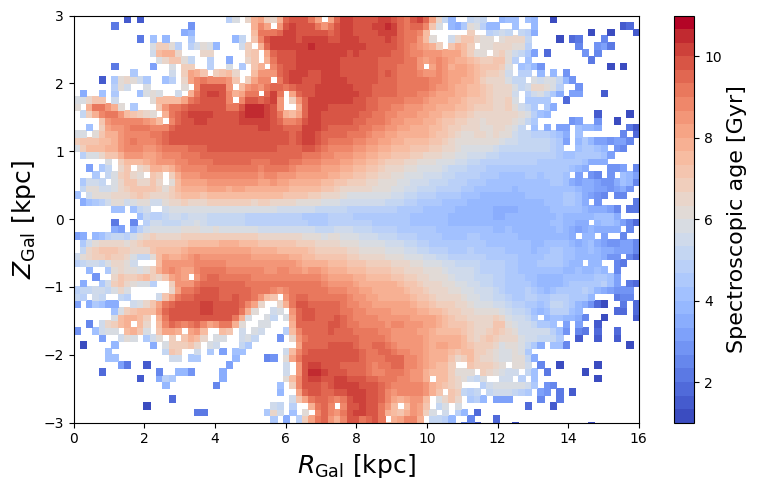

In [86]:
f, (a1) = plt.subplots(1, 1, figsize=(8,5))

rz_range = [0, 18, -5, 5]

XX, YY, H = create_median_map(our_cat["Rg"], our_cat["Zg"],
                              xy_range=rz_range,
                              weights = our_cat['spec_age_feb2023'],
                              bins=100)
cmap = plt.get_cmap('coolwarm', 30)
image = a1.pcolor(XX, YY, H.T, cmap=cmap, vmin=1, vmax=11)
cax = plt.colorbar(image)
cax.set_label(r"Spectroscopic age [Gyr]", fontsize=16)

a1.axis([0, 16, -3, 3])
a1.set_xlabel(r"$R_{\rm Gal}$ [kpc]", fontsize=18)
a1.set_ylabel(r"$Z_{\rm Gal}$ [kpc]", fontsize=18)

plt.tight_layout()
plt.savefig("../im/RZ_agecoloured.png")

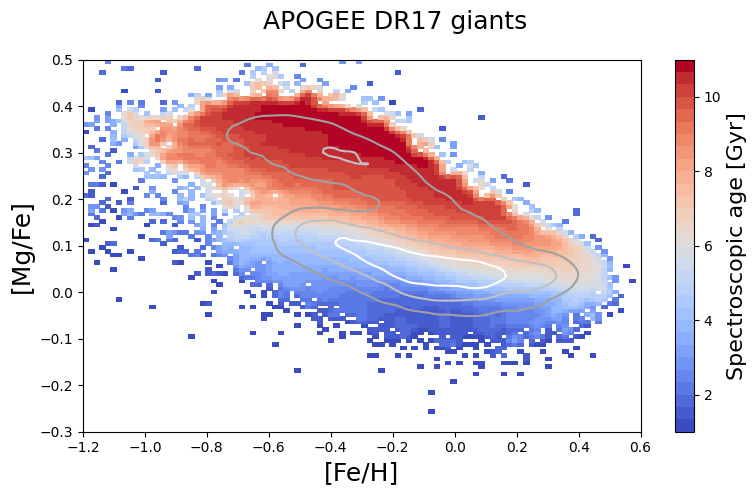

In [96]:
f, (a1) = plt.subplots(1, 1, figsize=(8,5))

mgfe_range = [-1.2, .6, -.3, .5]

XX, YY, H = create_median_map(our_cat["FE_H"], our_cat["MG_FE"],
                              xy_range=mgfe_range,
                              weights = our_cat['spec_age_feb2023'],
                              bins=100)
cmap = plt.get_cmap('coolwarm', 30)
image = a1.pcolor(XX, YY, H.T, cmap=cmap, vmin=1, vmax=11, label="APOGEE DR17 giants")
# Overplot contours
# Unweighted 2D Histogram
Ht,X1,X2 = np.histogram2d(our_cat["FE_H"], our_cat["MG_FE"], 
                          bins=100, range=[mgfe_range[:2], mgfe_range[2:]])
H = ndimage.gaussian_filter(Ht,sigma=(1.0,1.0),order=0)

plt.contour(X1[:-1], X2[:-1], H.T, levels=[30, 100, 200],
            colors=['#A0A0A0', '#C0C0C0', 'white'])

cax = plt.colorbar(image)
cax.set_label(r"Spectroscopic age [Gyr]", fontsize=16)

a1.axis(mgfe_range)
a1.set_xlabel(r"[Fe/H]", fontsize=18)
a1.set_ylabel(r"[Mg/Fe]", fontsize=18)

plt.suptitle("APOGEE DR17 giants", fontsize=18)
plt.tight_layout()
plt.savefig("../im/mgfe_agecoloured.png")

In [88]:
delgadomena = Table.read("../data/DelgadoMena20172019.fits")

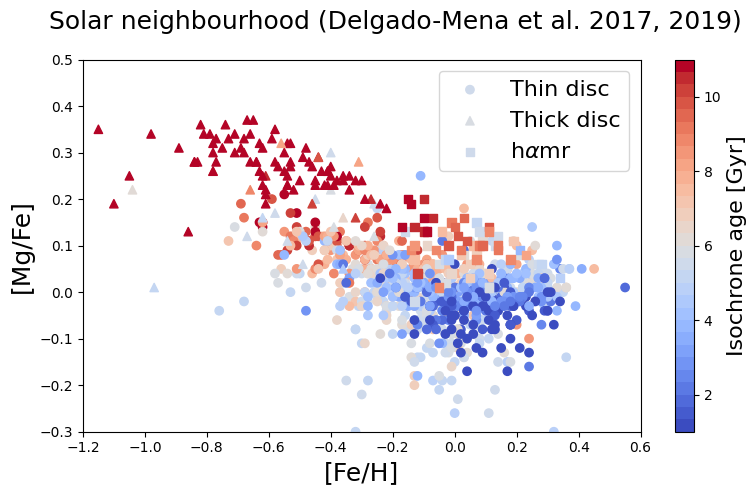

In [99]:
f, (a1) = plt.subplots(1, 1, figsize=(8,5))

mgfe_range = [-1.2, .6, -.3, .5]
cmap = plt.get_cmap('coolwarm', 30)

pops = ["thin", "thick", "high"]
syms = ["o", "^", "s"]
labels = ["Thin disc", "Thick disc", r"h$\alpha$mr"]

for jj in [0,1,2]: 
    sc = plt.scatter(delgadomena["__Fe_H_"][delgadomena["pop"]==pops[jj]], 
                     delgadomena["__MgI_Fe_"][delgadomena["pop"]==pops[jj]], 
                     c=delgadomena["Age"][delgadomena["pop"]==pops[jj]], 
                     cmap=cmap, marker=syms[jj], vmin=1, vmax=11, label=labels[jj])

    plt.legend(loc="upper right", fontsize=16)
cax = plt.colorbar(sc)
cax.set_label(r"Isochrone age [Gyr]", fontsize=16)

a1.axis(mgfe_range)
a1.set_xlabel(r"[Fe/H]", fontsize=18)
a1.set_ylabel(r"[Mg/Fe]", fontsize=18)

plt.suptitle("Solar neighbourhood (Delgado-Mena et al. 2017, 2019)", fontsize=18)
plt.tight_layout()
plt.savefig("../im/mgfe_agecoloured_delgadomena.png")

## What next?

In [46]:
def running_median(X, Y, nbins=10):
    bins = np.linspace(X.min(),X.max(), nbins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(X, bins, right=False)
    med = [np.quantile(Y[idx==k], 0.5) for k in range(1, nbins)]
    q16 = [np.quantile(Y[idx==k], 0.16) for k in range(1, nbins)]
    q84 = [np.quantile(Y[idx==k], 0.84) for k in range(1, nbins)]
    return bins[1:] - delta/2, med, q16, q84

# Overplot running median
def overplot_trend(X, Y, alpha=0.2, color="k", bins=10):
    #lines = mdline(X, Y, bins=bins)
    lines = running_median(X, Y, nbins=bins)
    xnew  = np.linspace(lines[0].min(), lines[0].max(), bins)
    spl   = make_interp_spline(lines[0], lines[1], k=2)
    power_smooth = spl(xnew)
    plt.plot(lines[0], lines[1], ms=50, color=color, lw=3)
    plt.fill_between(lines[0], lines[2], lines[3], alpha=alpha, color=color)